In [1]:
import numpy as np

from robust_smc.data import TANSimulator, dem
from robust_smc.sampler import LinearGaussianBPF, RobustifiedLinearGaussianBPF

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
time = 200
time_step = 0.1
observation_std = 20.0

seed = 1992

num_samples = 1000

In [3]:
# process_std = np.array([1.   , 1.   , 3.   , 0.145, 0.228, 1.15 ]) * 1e-1
process_std = None
simulator = TANSimulator(time, time_step=time_step, observation_std=observation_std,
                         process_std=process_std, seed=seed)

In [4]:
transition_matrix = simulator.transition_matrix
transition_cov = np.diag(simulator.process_std ** 2)
observation_cov = simulator.observation_std ** 2

In [5]:
prior_std = np.array([1e-1, 1e-1, 1.0, 1e-2, 1e-2, 1e-1])
X_init = simulator.X0[None, :] + prior_std[None, :] * np.random.randn(num_samples, 6)
X_init = X_init.squeeze()

In [6]:
vanilla_bpf = LinearGaussianBPF(
    data=simulator.Y,
    transition_matrix=transition_matrix, 
    transition_cov=transition_cov, 
    X_init=X_init, 
    observation_model=simulator.observation_model,
    num_samples=num_samples,
    observation_cov=observation_cov
)
vanilla_bpf.sample()

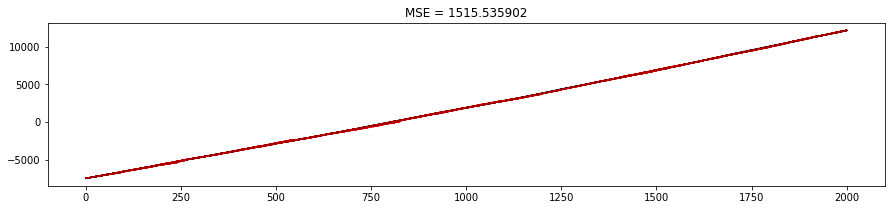

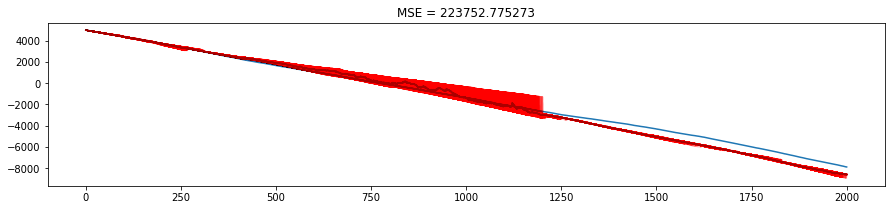

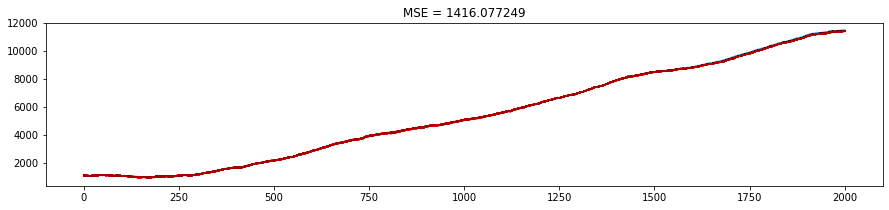

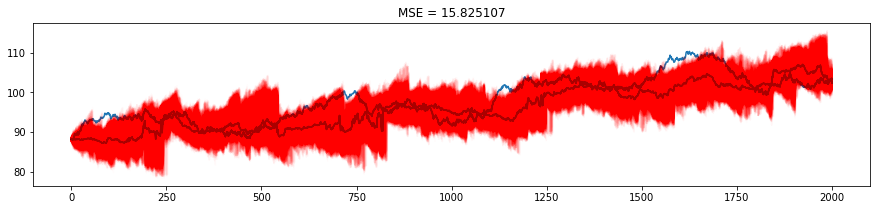

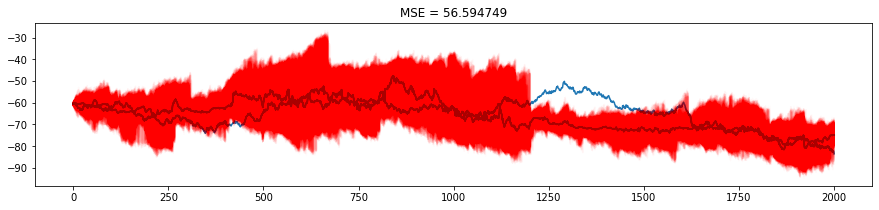

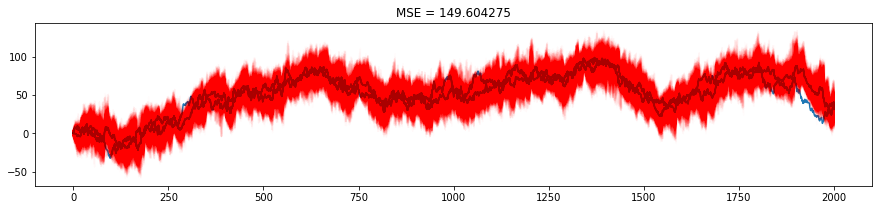

In [7]:
for var in range(6):
    plt.figure(figsize=(15, 3))
    traj = np.stack(vanilla_bpf.X_trajectories)
    plt.plot(simulator.X[:, var])
    mean = traj[:, :, var].mean(axis=1)
    plt.plot(mean, c='k', alpha=0.8, ls='-')
    mse = mean_squared_error(simulator.X[:, var], mean)
    for i in range(num_samples):
        plt.plot(traj[:, i, var], c='r', alpha=0.01, ls='-')
        lims = (np.min(traj[:, i, var]), np.max(traj[:, i, var]))
#         plt.ylim(lims[0] - 5., lims[1] + 5.0)
        plt.title('MSE = {:4f}'.format(mse))

Text(0.5, 1.0, 'Effective sample size with time')

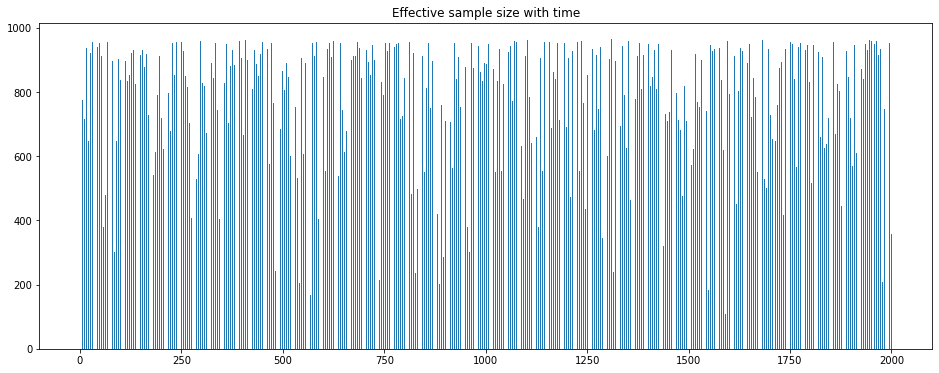

In [8]:
ess = [vanilla_bpf.effective_sample_size(logw) for logw in vanilla_bpf.logw]

plt.figure(figsize=(16, 6))
plt.bar(range(len(ess)), ess, width=0.4)
plt.title('Effective sample size with time')
# plt.ylim((600, 1000));

In [9]:
robust_bpf = RobustifiedLinearGaussianBPF(
    beta=0.1,
    data=simulator.Y,
    transition_matrix=transition_matrix, 
    transition_cov=transition_cov, 
    X_init=X_init, 
    observation_model=simulator.observation_model,
    num_samples=num_samples,
    observation_cov=observation_cov
)
robust_bpf.sample()

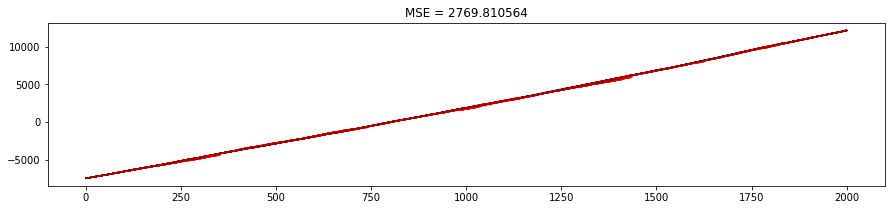

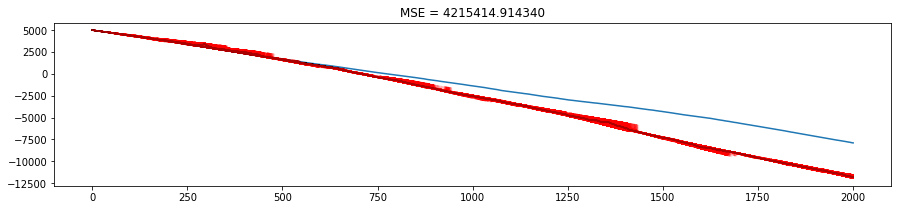

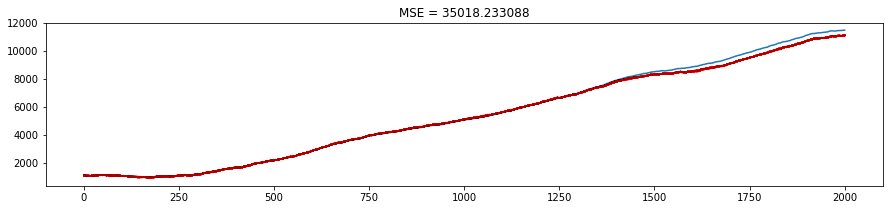

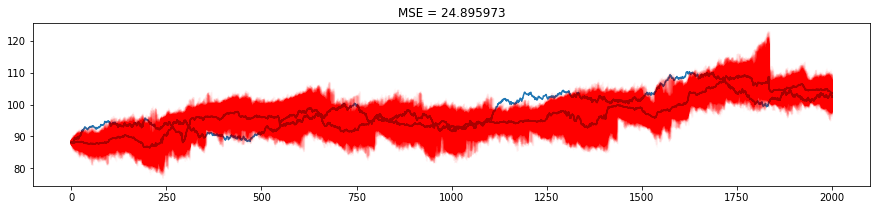

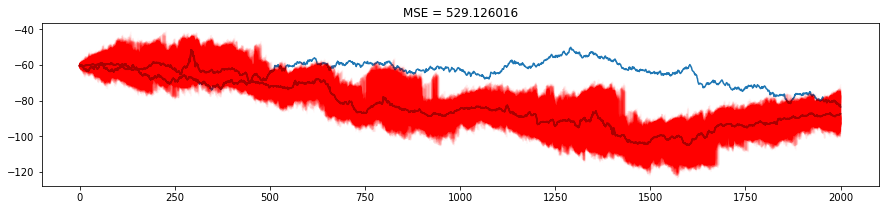

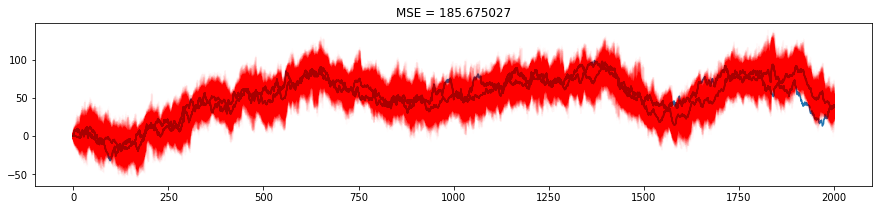

In [10]:
for var in range(6):
    plt.figure(figsize=(15, 3))
    traj = np.stack(robust_bpf.X_trajectories)
    plt.plot(simulator.X[:, var])
    mean = traj[:, :, var].mean(axis=1)
    plt.plot(mean, c='k', alpha=0.8, ls='-')
    mse = mean_squared_error(simulator.X[:, var], mean)
    for i in range(num_samples):
        plt.plot(traj[:, i, var], c='r', alpha=0.01, ls='-')
        lims = (np.min(traj[:, i, var]), np.max(traj[:, i, var]))
#         plt.ylim(lims[0] - 5., lims[1] + 5.0)
        plt.title('MSE = {:4f}'.format(mse))

Text(0.5, 1.0, 'Effective sample size with time')

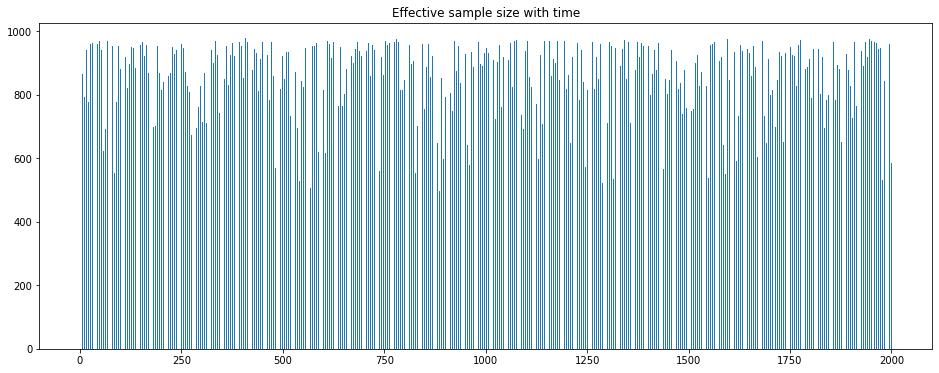

In [11]:
ess = [robust_bpf.effective_sample_size(logw) for logw in robust_bpf.logw]

plt.figure(figsize=(16, 6))
plt.bar(range(len(ess)), ess, width=0.4)
plt.title('Effective sample size with time')
# plt.ylim((600, 1000));

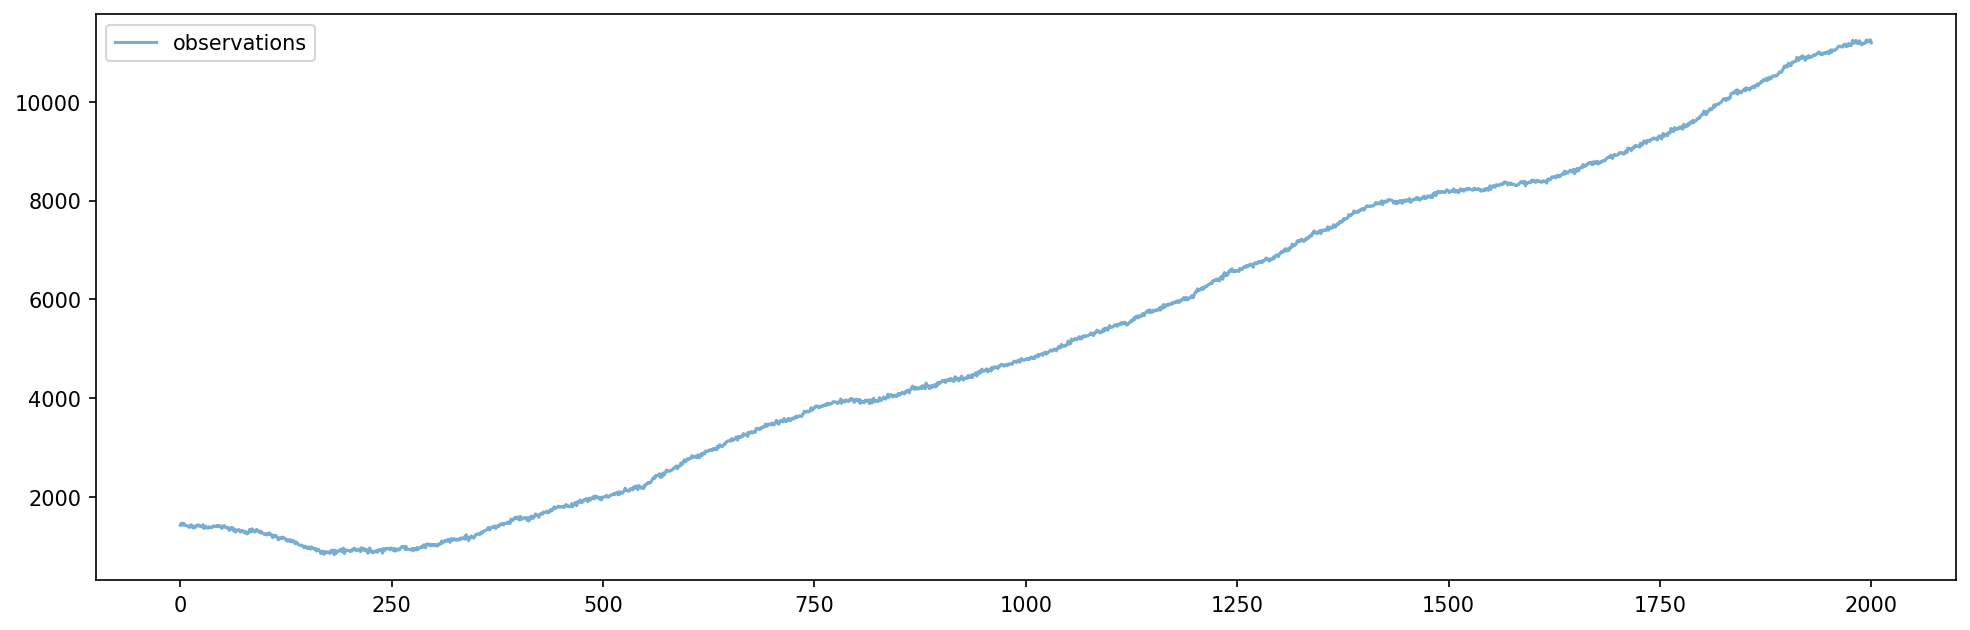

In [12]:
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(simulator.Y, label='observations', alpha=0.6)
plt.legend()